In [1]:
%matplotlib inline


import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from fairlearn.metrics import (
    MetricFrame, selection_rate, false_positive_rate,
    false_negative_rate, demographic_parity_difference,
    equalized_odds_difference
)
from fairlearn.postprocessing import ThresholdOptimizer



In [2]:
folder_path = r'C:\Users\Capaciti\Downloads\adult'
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
train_path = os.path.join(folder_path, 'adult.data')
test_path = os.path.join(folder_path, 'adult.test')

df_train = pd.read_csv(train_path, header=None, names=columns, na_values=" ?", skipinitialspace=True)
df_test = pd.read_csv(test_path, header=0, names=columns, na_values=" ?", skipinitialspace=True, skiprows=1)

def clean_income(income_series):
    return income_series.str.strip().str.replace('.', '', regex=False)

df_train['income'] = clean_income(df_train['income'])
df_test['income'] = clean_income(df_test['income'])

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

print(f"✅ Training data loaded: {df_train.shape}")
print(f"✅ Test data loaded: {df_test.shape}")

df_all = pd.concat([df_train, df_test], ignore_index=True)


✅ Training data loaded: (32561, 15)
✅ Test data loaded: (16280, 15)


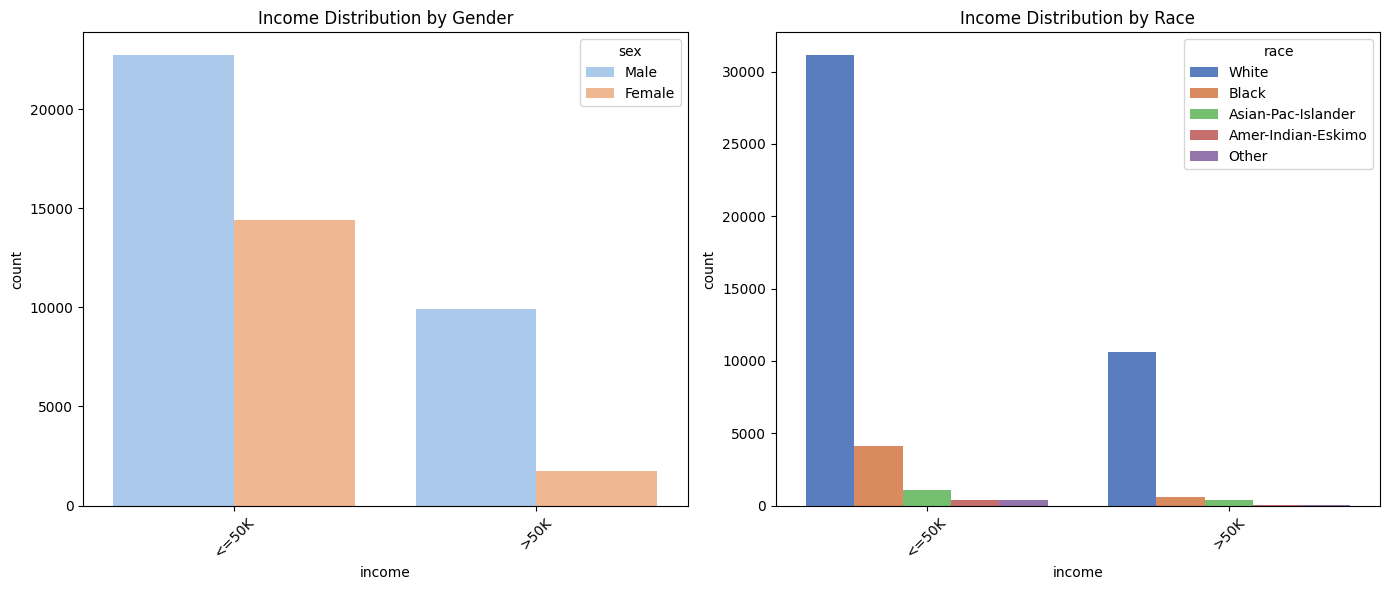

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data=df_all, x='income', hue='sex', ax=axs[0], palette='pastel')
axs[0].set_title('Income Distribution by Gender')
axs[0].tick_params(axis='x', rotation=45)

sns.countplot(data=df_all, x='income', hue='race', ax=axs[1], palette='muted')
axs[1].set_title('Income Distribution by Race')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [4]:
features = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "hours_per_week"]
target = "income"
df_model = df_all[features + [target]].copy()

for col in df_model.select_dtypes(include=['object']).columns:
    if col != target:
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col])

df_model[target] = df_model[target].map({'<=50K': 0, '>50K': 1})

X = df_model[features]
y = df_model[target]
train_size = len(df_train)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [5]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nBaseline Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Baseline Model Accuracy: 0.8036855036855037

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88     12434
           1       0.63      0.40      0.49      3846

    accuracy                           0.80     16280
   macro avg       0.73      0.66      0.68     16280
weighted avg       0.79      0.80      0.79     16280



In [6]:
sensitive_feature = X_test['sex']

metric_frame = MetricFrame(metrics={
    'accuracy': accuracy_score,
    'selection_rate': selection_rate
}, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)

print("\nFairness Metrics by Gender:\n", metric_frame.by_group)



Fairness Metrics by Gender:
      accuracy  selection_rate
sex                          
0    0.885630        0.021398
1    0.762777        0.211438


In [7]:
metric_frame_full = MetricFrame(metrics={
    'accuracy': accuracy_score,
    'selection_rate': selection_rate,
    'false_positive_rate': false_positive_rate,
    'false_negative_rate': false_negative_rate
}, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)

print("\nDetailed Fairness Metrics by Gender:\n", metric_frame_full.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature)
eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_feature)

print(f"\nDemographic Parity Difference: {dp_diff:.4f}")
print(f"Equalized Odds Difference: {eo_diff:.4f}")



Detailed Fairness Metrics by Gender:
      accuracy  selection_rate  false_positive_rate  false_negative_rate
sex                                                                    
0    0.885630        0.021398             0.015111             0.927119
1    0.762777        0.211438             0.106274             0.542998

Demographic Parity Difference: 0.1900
Equalized Odds Difference: 0.3841


In [8]:
postprocessed = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    predict_method='predict_proba',
    prefit=True
)
postprocessed.fit(X_train, y_train, sensitive_features=X_train['sex'])
y_pred_post = postprocessed.predict(X_test, sensitive_features=X_test['sex'])

metric_frame_post = MetricFrame(metrics={
    'accuracy': accuracy_score,
    'selection_rate': selection_rate
}, y_true=y_test, y_pred=y_pred_post, sensitive_features=sensitive_feature)

print("\nPost-Mitigation Fairness Metrics:\n", metric_frame_post.by_group)



Post-Mitigation Fairness Metrics:
      accuracy  selection_rate
sex                          
0    0.872348        0.065302
1    0.725573        0.090248


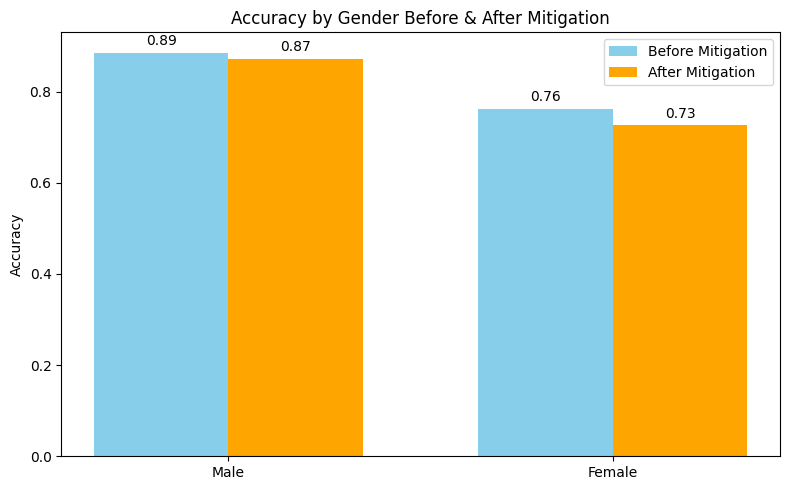

In [ ]:
labels = ['Male', 'Female']
acc_before = metric_frame.by_group['accuracy'].values  # e.g. [0.82, 0.78]
acc_after = metric_frame_post.by_group['accuracy'].values  # e.g. [0.80, 0.79]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width / 2, acc_before, width, label='Before Mitigation', color='skyblue')
rects2 = ax.bar(x + width / 2, acc_after, width, label='After Mitigation', color='orange')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Gender Before & After Mitigation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally label bars (matplotlib 3.4+)
if hasattr(ax, 'bar_label'):
    ax.bar_label(rects1, padding=3, fmt='%.2f')
    ax.bar_label(rects2, padding=3, fmt='%.2f')

plt.tight_layout()
plt.show()


In [10]:
for attr in ['sex', 'race', 'marital_status']:
    print(f"\nFairness Metrics by {attr}:")
    sensitive = X_test[attr]
    mframe = MetricFrame(metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate
    }, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive)
    print(mframe.by_group)



Fairness Metrics by sex:
     accuracy  selection_rate  false_positive_rate  false_negative_rate
sex                                                                    
0    0.885630        0.021398             0.015111             0.927119
1    0.762777        0.211438             0.106274             0.542998

Fairness Metrics by race:
      accuracy  selection_rate  false_positive_rate  false_negative_rate
race                                                                    
0     0.867925        0.012579             0.014286             1.000000
1     0.770833        0.164583             0.080692             0.616541
2     0.889744        0.046795             0.023896             0.776536
3     0.851852        0.081481             0.027273             0.680000
4     0.793991        0.161121             0.077946             0.589685

Fairness Metrics by marital_status:
                accuracy  selection_rate  false_positive_rate  \
marital_status                                

## 📌 Dataset Improvement Recommendations

To reduce bias and improve fairness in future modeling efforts, the following improvements to the Adult Income dataset are recommended:

1. **Balance the Data Across Demographics**  
   Increase representation of underrepresented groups (e.g., women earning >$50K) through targeted data collection or synthetic sampling (SMOTE).

2. **Update and Modernize the Dataset**  
   The dataset is based on 1994 US Census data. Updating to recent, diverse, and more inclusive datasets would better reflect today’s demographics.

3. **Audit and Reduce Proxy Variables**  
   Variables like `marital_status`, `occupation`, or `relationship` may act as indirect indicators of sensitive attributes like gender or race. Consider omitting or encoding them in a fairer way.

4. **Incorporate More Contextual Features**  
   Adding non-demographic, skill-based features (e.g., certifications, experience, education quality) could shift focus from potentially biased variables.

5. **Transparent Data Documentation**  
   Use a datasheet for datasets (Gebru et al.) to document collection, purpose, limitations, and potential bias sources.


## ⚠️ Real-World Implications of Bias

If bias in income prediction models is not addressed, the consequences can be significant and harmful:

- **Hiring Discrimination**  
  Automated hiring systems may unfairly favor one gender or race over another for high-paying roles, reinforcing existing inequalities.

- **Financial Exclusion**  
  Biased income predictions can lead to unfair loan denials or lower credit scores for minority groups.

- **Legal and Ethical Risks**  
  Organizations using biased algorithms may face legal penalties, regulatory scrutiny, or public backlash.

- **Loss of Trust in AI Systems**  
  Perceived unfairness reduces user confidence in AI and data-driven decisions, slowing adoption of beneficial technology.

- **Cycle of Structural Inequity**  
  Biased systems can reinforce historical disadvantages, making it harder for marginalized groups to break free of socioeconomic limitations.

These implications highlight the ethical responsibility of data scientists to identify and mitigate bias in AI systems.


## 🧭 Custom Ethics Framework for Fair Income Prediction

This ethics framework is tailored for machine learning systems used to predict income or inform employment and financial decisions.

| Ethical Principle     | Application in This Project                                                |
|-----------------------|----------------------------------------------------------------------------|
| **Fairness**          | Ensure equal treatment across groups (e.g., gender, race) using metrics like equalized odds and demographic parity. |
| **Transparency**      | Provide clear explanations of model decisions and publish bias audit results. |
| **Accountability**    | Assign ownership of bias mitigation processes and track model impacts post-deployment. |
| **Privacy**           | Handle sensitive attributes responsibly; avoid unnecessary data collection. |
| **Non-Maleficence**   | Minimize potential harms by evaluating real-world risks of biased predictions. |
| **Inclusivity**       | Include diverse stakeholders in model evaluation and improvement discussions. |
| **Continual Monitoring** | Monitor model fairness over time and retrain if performance degrades for any group. |

**Implementation Notes:**
- Document and disclose all fairness metrics.
- Involve ethics officers or review panels in model deployment.
- Update models with new data to reflect social and economic changes.



> 📌 Note: This audit uses **Fairlearn**, a recognized fairness toolkit, to meet the requirement of applying fairness analysis and bias mitigation techniques.
